<a href="https://colab.research.google.com/github/Chevron9/iannwtf/blob/master/td3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("BipedalWalker-v3")

     |████████████████████████████████| 450kB 9.1MB/s 


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
import sys
print(f"Python version {sys.version}")
print(sys.path)

import os 
print(f"Current working directory is {os.getcwd()}")

import gym
import tensorflow as tf
print(f"TF version: {tf.version.VERSION}")
import numpy as np
import time

Python version 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']
Current working directory is /content
TF version: 2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt

#plots the scores of the course of training
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [4]:
def timespan_format(timespan):
    timespan = round(timespan)
    h_full = timespan / (60*60)
    h = timespan // (60*60)
    m = (timespan % (60*60)) // 60
    s = timespan % 60
    time = f"{h:02}:{m:02}:{s:02}"
    if h_full > 24:
        d = timespan // (60*60*24)
        h = (timespan % (60*60*24)) // (60*60)
        time = f"{d:02}::{h:02}:{m:02}:{s:02}"
    return time

timespan_format(303601)
test = False
if test:
    assert timespan_format(60) == "00:01:00"
    assert timespan_format(60*60) == "01:00:00"
    assert timespan_format(60*60+1) == "01:00:01"
    assert timespan_format(60*60+60) == "01:01:00"
    assert timespan_format(24*60*60+1) == "01::00:00:01"
    assert timespan_format(303601) == "03::12:20:01" # 3 days 12 hours 20 minutes 1 second


In [5]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

#all the networks of the model


#critic network that takes the state and the action and puts out the value of the
#the action in the given state
class CriticNetwork(keras.Model):
    def __init__(self, dense1=512, dense2=512,
            name='critic', chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()
        #Dimensions of the dense layers
        self.dense1 = dense1
        self.dense2 = dense2


        #says where the weights are saved
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir,
                    self.model_name+'_td3.h5')

        
        #Optimization: using LeakyReLU as per https://arxiv.org/pdf/1709.06560.pdf

        #dense layers with kernel and bias initializer(from an other implementation)
        #and relu activation
        f1 = 1. / np.sqrt(self.dense1)
        self.dense_layer1 = Dense(self.dense1, activation= tf.nn.leaky_relu,
        kernel_initializer = tf.keras.initializers.RandomUniform(-f1, f1),
        bias_initializer = tf.keras.initializers.RandomUniform(-f1, f1))


        f2 = 1. / np.sqrt(self.dense2)
        self.dense_layer2 = Dense(self.dense2, activation= tf.nn.leaky_relu,
        kernel_initializer = tf.keras.initializers.RandomUniform(-f2, f2),
        bias_initializer = tf.keras.initializers.RandomUniform(-f2, f2))

        #denselayer with 1 neuron that gives the estimated q value of the
        #state-action pair
        f3 = 0.003
        self.q = Dense(1, activation=None, kernel_initializer = tf.keras.initializers.RandomUniform(-f3, f3),
        bias_initializer = tf.keras.initializers.RandomUniform(-f3, f3),
        kernel_regularizer=tf.keras.regularizers.l2(0.01))

    @tf.function
    def call(self, state, action, training = True):
        #feeds the network state and action pairs
        action_value = self.dense_layer1(tf.concat([state, action], axis=1))

        action_value = self.dense_layer2(action_value)

        q = self.q(action_value)

        #gives back an estimation of a q value
        return q


#actor network that takes the state and outputs a probability
#distribution over all possible actions
class ActorNetwork(keras.Model):
    def __init__(self, dense1=512, dense2=512, n_actions=4, name='actor',
            chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()
        self.dense1 = dense1
        self.dense2 = dense2
        self.n_actions = n_actions


        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir,
                    self.model_name+'_td3.h5')

        #first dense layer
        f1 = 1. / np.sqrt(self.dense1)
        self.dense_layer1 = Dense(self.dense1, activation= tf.keras.activations.relu,
        kernel_initializer = tf.keras.initializers.RandomUniform(-f1, f1),
        bias_initializer = tf.keras.initializers.RandomUniform(-f1, f1))


        #second dense layer
        f2 = 1. / np.sqrt(self.dense2)
        self.dense_layer2 = Dense(self.dense2, activation= tf.keras.activations.relu,
        kernel_initializer = tf.keras.initializers.RandomUniform(-f2, f2),
        bias_initializer = tf.keras.initializers.RandomUniform(-f2, f2))


        #output layer with tanh activation to get an output vector of length actionspace
        #with values between -1 and 1 to fit to the action boundaries
        f3 = 0.003
        self.mu = Dense(self.n_actions, activation='tanh', kernel_initializer = tf.keras.initializers.RandomUniform(-f3, f3), 
                        bias_initializer= tf.keras.initializers.RandomUniform(-f3, f3))

    @tf.function
    def call(self, state, training = True):

        actions = self.dense_layer1(state)
        actions = self.dense_layer2(actions)

        #gives back the actions the agent should take (deterministic policy)
        actions = self.mu(actions)


        return actions


In [6]:
import numpy as np

# Replaybuffer that stores all informations about the agents transitions
# in np arrays
class ReplayBuffer:
    #initializes the memories with zeros with sizes depending on a big maximal size,
    #the input_dimensions(output of the environment) or the numbers of possible
    #actions
    def __init__(self, max_size, input_shape, n_actions):
        self.max_size = max_size
        self.current_position = 0
        self.state_memory = np.zeros((self.max_size, *input_shape))
        self.new_state_memory = np.zeros((self.max_size, *input_shape))
        self.action_memory = np.zeros((self.max_size, n_actions))
        self.reward_memory = np.zeros(self.max_size)
        self.terminal_memory = np.zeros(self.max_size, dtype=np.bool)

    #stores new transitions in memory
    def store_transition(self, state, action, reward, state_, done):
        index = self.current_position % self.max_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.current_position+= 1

    #gives back a random batch of of transition samples
    def sample_buffer(self, batch_size):
        #makes sure to have the correct current size of the memory
        max_mem = min(self.current_position, self.max_size)

        #selects a random batch of indexes in the memory size
        batch = np.random.choice(max_mem, batch_size, replace=False)

        #retrieves the batch from memory
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


In [7]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

# the agent class where the all the important parameters and systems of the
# model are managed

class Agent:
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,
            gamma=0.99, n_actions=4, max_size=1000000, tau=0.001,
            dense1=512, dense2=512, batch_size=128, noise=0.3, module_dir = ""):

        #initializing network-parameters
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        
        self.delay = 0 # this governs if we wanna update the actor this step or not
        self.delay_threshold = 2 #we want to update the actor every x steps

        #retrieves the maximum and minimum of the actionvalues
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]

        #initializes the Replaybuffer which stores what the agents does
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        
        # initializing the Networks with given parameters
        # target_actor and target_critic are just initialized as the actor and
        # critic networks

        chkpt_dir = module_dir+"/tmp"
        self.actor = ActorNetwork(n_actions=n_actions, name='actor', dense1 = dense1, dense2 = dense2, chkpt_dir=chkpt_dir)
        self.target_actor = ActorNetwork(n_actions=n_actions, name='target_actor',  dense1 = dense1, dense2 = dense2, chkpt_dir=chkpt_dir)



        # The critics might be better handled in a list, but this might slow down tensorflow performance
        self.critic1 = CriticNetwork(name='critic1',  dense1 = dense1, dense2 = dense2, chkpt_dir=chkpt_dir)
        self.target_critic1 = CriticNetwork(name='target_critic1', dense1 = dense1, dense2 = dense2, chkpt_dir=chkpt_dir)

        self.critic2 = CriticNetwork(name='critic2',  dense1 = dense1, dense2 = dense2, chkpt_dir=chkpt_dir)
        self.target_critic2 = CriticNetwork(name='target_critic2', dense1 = dense1, dense2 = dense2, chkpt_dir=chkpt_dir)


        #compile the networks with learning rates
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        
        self.critic1.compile(optimizer=Adam(learning_rate=beta))
        self.target_critic1.compile(optimizer=Adam(learning_rate=beta))

        self.critic2.compile(optimizer=Adam(learning_rate=beta))
        self.target_critic2.compile(optimizer=Adam(learning_rate=beta))

        self.update_network_parameters(tau=1, delay = False) #Hard copy, since this is the initialization

    #updates the target networks
    #soft copies the target and actor network dependent on tau
    def update_network_parameters(self, tau=None, delay = False):
        if tau is None:
            tau = self.tau

        if not delay:
            weights = []
            targets = self.target_actor.weights
            for i, weight in enumerate(self.actor.weights):
                weights.append(weight * tau + targets[i]*(1-tau))
            self.target_actor.set_weights(weights)


        # critics copying to target critics
        weights = []
        targets = self.target_critic1.weights
        for i, weight in enumerate(self.critic1.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic1.set_weights(weights)

        weights = []
        targets = self.target_critic2.weights
        for i, weight in enumerate(self.critic2.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic2.set_weights(weights)

    #stores the state, action, reward transition
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    #saves models in files
    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.critic1.save_weights(self.critic1.checkpoint_file)
        self.target_critic1.save_weights(self.target_critic1.checkpoint_file)
        self.critic2.save_weights(self.critic2.checkpoint_file)
        self.target_critic2.save_weights(self.target_critic2.checkpoint_file)

    #loads models from files
    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.critic1.load_weights(self.critic1.checkpoint_file)
        self.target_critic1.load_weights(self.target_critic1.checkpoint_file)
        self.critic2.load_weights(self.critic2.checkpoint_file)
        self.target_critic2.load_weights(self.target_critic2.checkpoint_file)

    #choose_action with help of the actor network, adds noise if it's for training
    
    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        
        # inject eploration noise
        if not evaluate:

            actions += tf.random.normal(shape=[self.n_actions],
                    mean=0.0, stddev=self.noise)

        #makes sure that action boundaries are met
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        return actions[0]

    #learn function of the networks
    def learn(self):
        # control problem: How to solve this problem? (or: picking policy) -> actor
        # leads to
        # prediction problem: Are my actiosn actually getting me closer to accomplishing my goal? (or: value function of policy) -> critic

        #starts to learn when there are enough samples to fill a batch
        if self.memory.current_position < self.batch_size:
            return

        #gets batch form memory
        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        #convert np arrays to tensors to feed them to the networks
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        #update critic network
        with tf.GradientTape(persistent=True) as tape:

            #call target actor to simulate which action to take
            target_actions = self.target_actor(states_)

            # TD3: Add noise regularization to policy
            # This is achieved by adding "clipped noise"
            # Noise is clipped to ensure the noisy actions aren't too far from policy.
            target_actions = target_actions + tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)

            # Clip again to make sure we aren't violating action space
            target_actions = tf.clip_by_value(target_actions, self.min_action, self.max_action)


            #target critic evaluates the value of the actions in the given states
            critic1_value_ = tf.squeeze(self.target_critic1(states_, target_actions), 1)

            #critic network evaluate the actual states and actions the model took
            critic1_value = tf.squeeze(self.critic1(states, actions), 1)


            critic2_value_ = tf.squeeze(self.target_critic2(states_, target_actions), 1)
            critic2_value = tf.squeeze(self.critic2(states, actions), 1)

            #target says what value of the action in a certain state should
            #be like
            target = rewards + self.gamma*tf.math.minimum(critic1_value_,critic2_value_)*(1-done)

            #takes the MSE of the target and the actual critic value as the loss
            critic1_loss = keras.losses.MSE(target, critic1_value)
            critic2_loss = keras.losses.MSE(target, critic2_value)


        #gets the gradients of the loss in respect to the parameters of the network
        critic1_network_gradient = tape.gradient(critic1_loss,
                                            self.critic1.trainable_variables)

        critic2_network_gradient = tape.gradient(critic2_loss,
                                            self.critic2.trainable_variables)

        #aplies the gradients to the critic network
        self.critic1.optimizer.apply_gradients(zip(
            critic1_network_gradient, self.critic1.trainable_variables))

        self.critic2.optimizer.apply_gradients(zip(
            critic2_network_gradient, self.critic2.trainable_variables))

        # The if/else makes sure we only update the actor every second step.
        if self.delay < (self.delay_threshold-1):
            self.delay += 1
            delayBool = True
        elif self.delay == (self.delay_threshold-1):
            delayBool = False
            #update the actor network
            with tf.GradientTape() as tape:
                #gets the policy of the actor in a state
                action_policy = self.actor(states)

                #loss of the actor is the negative value of the critic because we
                #want to maximize the value but gradient descent minimizes
                # We are using Critic1 Loss here, as this is how it's done in the original paper.
                
                # It would be interesting to plot how c1 and c2 loss differ over time.

                actor_loss = -(self.critic1(states, action_policy))

                #the loss is a average of all the losses
                actor_loss = tf.math.reduce_mean(actor_loss)

            #gradients of the loss in respect to the parameters of the actor network
            actor_network_gradient = tape.gradient(actor_loss,
                                        self.actor.trainable_variables)


            #optimizing the network gradients
            self.actor.optimizer.apply_gradients(zip(
                actor_network_gradient, self.actor.trainable_variables))

            self.delay = 0
        else:
            raise Exception(f"Delay has been set incorrectly. Delay is {self.delay}, Threshold is {self.threshold}.")

        self.update_network_parameters(delay=delayBool)


Python version 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']
Current working directory is /content
TF version: 2.4.1

----------------- Training started at 2021-04-01-11:34:48. -------------------
checkpoint: False


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


... saving models ...
11:34:56 
Episode: **1**/5000, Score: -102 (Δ-101.8)
Average score: -101.8 (Δ-101.77)
Episode time: 8.0s, average: 8.0s (±0.00), ETA: 11:06:40 (11:06:40 to 11:06:40)
Steps: 69. Time per step: 1.2e-01s. Reward per step: -1.47.
It has been 0 episode(s) since the model was last saved, with a score of -102 (Δ0.00).

11:34:58 
Episode: **2**/5000, Score: -103 (Δ -0.9)
Average score: -102.2 (Δ-0.45)
Episode time: 2.0s, average: 5.0s (±9.00), ETA: 06:56:35 (02:46:38 to 19:26:26)
Steps: 62. Time per step: 3.2e-02s. Reward per step: -1.66.
It has been 1 episode(s) since the model was last saved, with a score of -102 (Δ-0.45).

11:35:01 
Episode: **3**/5000, Score: -106 (Δ -3.4)
Average score: -103.5 (Δ-1.28)
Episode time: 3.0s, average: 4.3s (±6.89), ETA: 06:00:58 (02:46:36 to 15:34:49)
Steps: 64. Time per step: 4.7e-02s. Reward per step: -1.66.
It has been 2 episode(s) since the model was last saved, with a score of -102 (Δ-1.73).

profiler started
11:35:07 
Episode: **4*

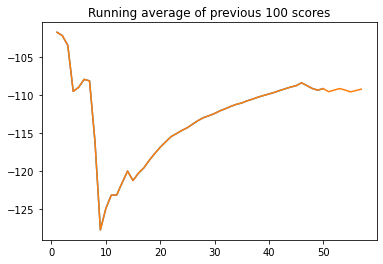

In [8]:
import sys
print(f"Python version {sys.version}")
print(sys.path)

import os 
print(f"Current working directory is {os.getcwd()}")

import gym
import tensorflow as tf
print(f"TF version: {tf.version.VERSION}")
import numpy as np
import time

# modules





# TD3 is an improvement on DDPG

# Actor network only updated every 2 steps

# 2 separate critic networks (and a target network for each of them)


# target policy smoothing
# TD3 reduces this variance by adding a small amount of random noise to the target and averaging over mini batches. 
# The range of noise is clipped in order to keep the target value close to the original action.

#TODO: Implement TD3

#TODO: Improve the loading loop, make sure the algorithm remembers what came before
# adjusting episodes
# adjusting plots
# adjusting tensorboard graphs etc
# statefulness

if __name__ == '__main__':

    #for the case you just want to load a previous model
    load_checkpoint = False

    #TODO maybe add some error handling if no checkpoint to load exists
    module_dir = ""

    #Housekeeping variables
    last_score = 0
    last_avg_score = 0
    last_save = 0
    avg_delta = []
    avg_steps = []

    t = t_start = time.localtime()
    current_time = time.strftime("%Y-%m-%d-%H:%M:%S", t)
    print(f"\n----------------- Training started at {current_time}. -------------------\ncheckpoint: {load_checkpoint}")


    figure_dir = module_dir+f'plots/'
    figure_file = figure_dir+f'walker{current_time.replace(":","_")}.png'

    log_dir = module_dir+'logs/' + current_time.replace(":","_")
    
    #Tensorboard writer  
    writer = tf.summary.create_file_writer(log_dir)


    #initialize the environment for the agent and initialize the agent
    
    #tf.debugging.set_log_device_placement(True)
    env = gym.make('BipedalWalker-v3')
    #env = gym.make('BipedalWalkerHardcore-v3')


    n_actions = env.action_space.shape[0]

    noise = 0.4
    # NEW batch 128
    agent = Agent(alpha=0.00005, beta=0.0005, input_dims=env.observation_space.shape, tau=0.001, env=env,
                  batch_size=128, dense1=512, dense2=512, n_actions=n_actions, noise = noise, module_dir = module_dir)


    episodes = 5000 #250



    #set bestscore to minimum
    best_score = env.reward_range[0]
    score_history = []


    #initializes the model with one random sample batch if model are loaded
    #you can't load an empty model for some reason
    #these are all dummy variables etc until load_models overwrites them
    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation = env.reset()
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            n_steps += 1
        agent.learn()
        agent.load_models()

    # ---------------------------------------
    # main learning loop
    # ---------------------------------------
    try:
        for i in range(episodes):
            if i == 3:
                tf.profiler.experimental.server.start(6009)
                print("profiler started")
                # launch tensorboard with "tensorboard --logdir logs"
                # capture profile
            #if i == 13:
            #    tf.profiler.experimental.stop
            #    print("profiler stopped")


            current_episode = i
            observation = env.reset()
            done = False
            score = 0
            
            #regulates the noise over the course of training as exponential
            #decay to get smaller noise at the end, the noise is the
            #standarddeviation of a normal distribution
            #(numbers from trial and error)
            agent.noise = noise * np.exp(-i/1500)

            #while the environment is running the model chooses actions, saves states,
            #rewards, actions and observations in the buffer and trains the networks
            #on them
            steps = 0
            while not done:
                action = agent.choose_action(observation)

                observation_, reward, done, info = env.step(action)
                steps += 1
                score += reward
                agent.remember(observation, action, reward, observation_, done)
                agent.learn()

                #saves previous observation
                observation = observation_

            score_history.append(score)
            avg_score = np.mean(score_history[-100:])

            #saves the model if the average score is better than the best previous
            if avg_score > best_score:
                best_score = avg_score
                agent.save_models()
                last_save = current_episode

            #calculating and giving some info on training progress
            t_new = time.localtime()
            current_time = time.strftime("%H:%M:%S", t_new)
            t_delta = time.mktime(t_new)-time.mktime(t)
            t = t_new
            
            # perhaps add a decaying factor for ETA
            avg_delta.append(t_delta)
            avg_delta_mean = np.mean(avg_delta)
            avg_delta_std = np.var(avg_delta)

            ETA_avg = (episodes-i)*avg_delta_mean
            ETA_min = (episodes-i)*max((avg_delta_mean-avg_delta_std),min(avg_delta))
            ETA_max = (episodes-i)*(avg_delta_mean+avg_delta_std)

            avg_steps.append(steps)
            per_step = t_delta/steps
            steps_per_score = score/steps

            print(f"{current_time} \n"
            f'Episode: **{i+1}**/{episodes}, Score: {score:.0f} (Δ{score-last_score:5.1f})\n'
            f'Average score: {avg_score:.1f} (Δ{avg_score-last_avg_score:5.2f})\n'
            f'Episode time: {t_delta:.1f}s, average: {avg_delta_mean:.1f}s (±{avg_delta_std:4.2f}),', 
            f'ETA: {timespan_format(ETA_avg)} ({timespan_format(ETA_min)} to {timespan_format(ETA_max)})\n'
            f'Steps: {steps}. Time per step: {per_step:.1e}s. Reward per step: {steps_per_score:.2f}.\n' 
            f'It has been {i - last_save} episode(s) since the model was last saved, with a score of {best_score:.0f} (Δ{avg_score-best_score:2.2f}).\n')

            last_score = score
            last_avg_score = avg_score
            

            with writer.as_default():
                tf.summary.scalar('Average Score', avg_score, step=i)
                tf.summary.scalar('Score', score, step=i)
                tf.summary.scalar('ETA', ETA_avg, step=i)
                tf.summary.scalar('Calculation time per step', per_step, step=i)
                tf.summary.scalar('Calculation time per episode', t_delta, step=i)
                tf.summary.scalar('Steps', steps, step=i)
                if ((i+1) % 50) == 0: #writer.flush and learning plot has a large performance impact, so only do it every 50 episodes
                    writer.flush()
                    x = [j+1 for j in range(current_episode+1)]
                    plot_learning_curve(x, score_history, figure_file)
                


            
    except KeyboardInterrupt:
        episodes = current_episode
        print("Manually shutting down training.")
    
    #plots the whole score history
    x = [i+1 for i in range(episodes)]
    plot_learning_curve(x, score_history, figure_file)

t2 = time.localtime()
current_time = time.strftime("%Y-%m-%d-%H:%M:%S", t2)
t_delta = time.mktime(t2)-time.mktime(t_start)
print(f"\n----------------- Training ended at {current_time}. Duration was {t_delta/60:.2f} minutes.-----------------")
